# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import string

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...

[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

for example in tqdm(dataset["train"]["text"]):
    processed_sentences = sent_tokenize(example)
    sentences.extend(
        [sentence for sentence in processed_sentences if len(word_tokenize(sentence)) < word_threshold]
    )
print(f"Количество предложений: {len(sentences)}")

  0%|          | 0/25000 [00:00<?, ?it/s]

Количество предложений: 198756


Посчитаем для каждого слова его встречаемость.

In [7]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence.lower()):
        words[word] += 1

  0%|          | 0/198756 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [8]:
vocab = set()
vocab_size = 40000

# Наполнение словаря
vocab.update(set(['<unk>', '<bos>', '<eos>', '<pad>']))
vocab.update(set([word[0] for word in words.most_common(vocab_size)]))

In [9]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [10]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [11]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [12]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        processed_sentence = (
            self.data[idx].lower()
            .translate(str.maketrans('', '', string.punctuation))
        )
        tokenized_sentence.extend([self.bos_id])
        tokenized_sentence.extend([word2ind.get(word, self.unk_id) for word in word_tokenize(processed_sentence)])
        tokenized_sentence.extend([self.eos_id])

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [13]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [14]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [15]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Val"):
            logits = model(batch["input_ids"]).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [16]:
def train_model(model, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=5):
    perplexities = []
    losses = []
    # Напишите код здесь
    for epoch in tqdm(range(epochs), desc="Эпоха"):
        model.train()
        epoch_losses = []
        for train_batch in tqdm(train_dataloader, desc="Train"):
            output = model(train_batch["input_ids"]).flatten(start_dim=0, end_dim=1)
            loss = criterion(output, train_batch["target_ids"].flatten())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses.append(loss.item())
        
        scheduler.step()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
        
    return perplexities, losses

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

##### Обучим базовую модель из семинара, заменив рекуррентный слой на LSTM

In [17]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.linear(output))
        prediction = self.projection(self.non_linear(output))

        return prediction

In [18]:
# Обучите модель здесь
model = LanguageModel(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [19]:
perplexities, losses = train_model(
    model, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=20
)

Эпоха:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

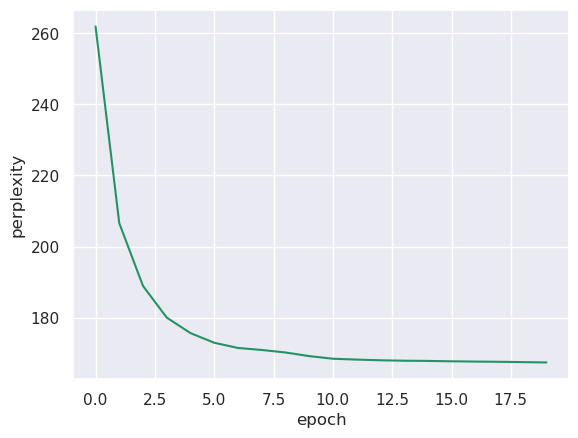

In [20]:
plt.plot(perplexities)
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.show()

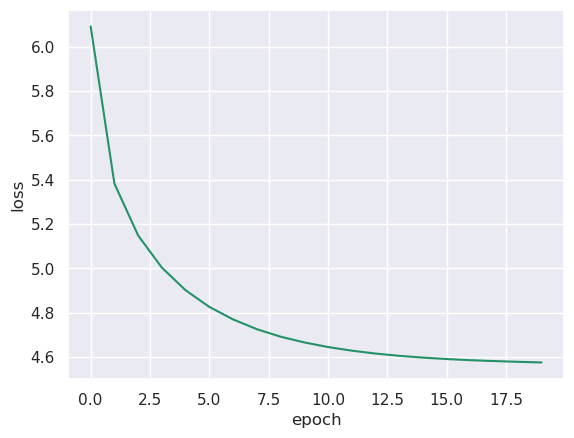

In [21]:
plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Видно, что в данном случае перплексия выходит на плато и не происходит переобучения.

##### Увеличим количество слоев LSTM

In [22]:
class LanguageModel2(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.linear(output))
        prediction = self.projection(self.non_linear(output))

        return prediction

In [23]:
# Обучите модель здесь
model2 = LanguageModel2(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model2.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [24]:
perplexities2, losses2 = train_model(
    model2, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=20
)

Эпоха:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

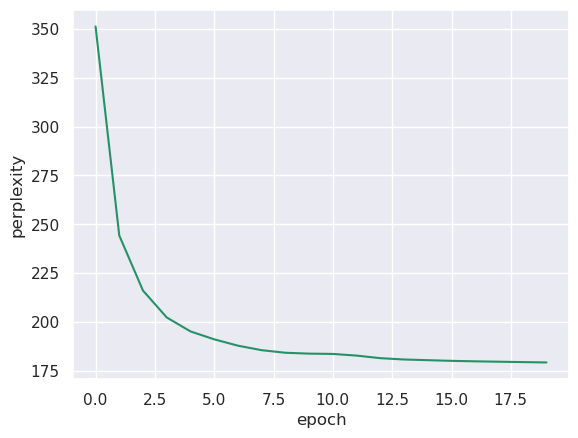

In [25]:
plt.plot(perplexities2)
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.show()

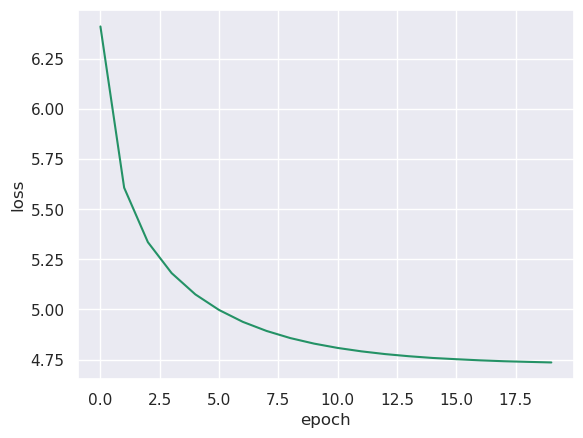

In [26]:
plt.plot(losses2)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Перплексия немного выросла по сравнению с однослойной LSTM.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

##### Увеличим размер скрытого состояния

In [27]:
# Обучите модель здесь
model3 = LanguageModel(1024, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model3.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [28]:
perplexities3, losses3 = train_model(
    model3, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=20
)

Эпоха:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

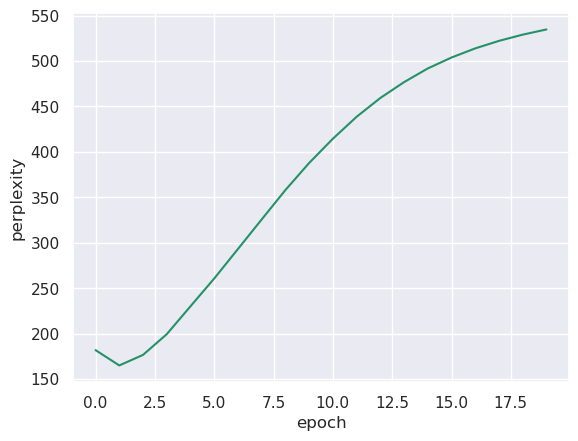

In [29]:
plt.plot(perplexities3)
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.show()

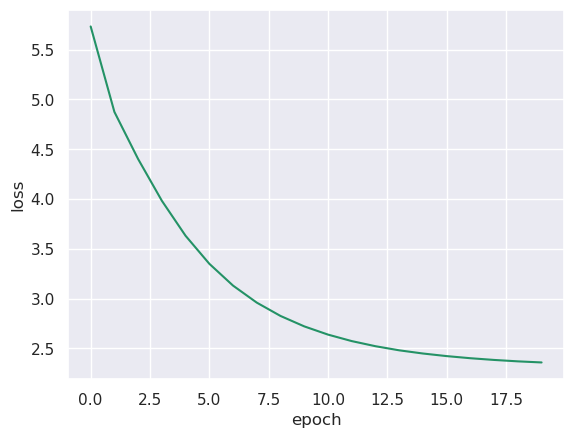

In [30]:
plt.plot(losses3)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Видно, что в данном случае быстро происходит переобучение модели.

##### Увеличим количество линейных слоев после LSTM

In [31]:
# Проведите второй эксперимент
class LanguageModel4(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear_up = nn.Linear(hidden_dim, 2 * hidden_dim)
        self.linear_down = nn.Linear(2 * hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        
        self.non_linear = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        
        # Опишите свою нейронную сеть здесь

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.lstm(embeddings)
        output = self.dropout(self.non_linear(self.linear_up(output)))
        output = self.dropout(self.non_linear(self.linear_down(output)))
        prediction = self.projection(output)

        return prediction

In [32]:
# Обучите модель здесь
model4 = LanguageModel4(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model4.parameters())
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)

In [33]:
perplexities4, losses4 = train_model(
    model4, criterion, optimizer, scheduler, train_dataloader, eval_dataloader, epochs=20
)

Эпоха:   0%|          | 0/20 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

Train:   0%|          | 0/1243 [00:00<?, ?it/s]

Val:   0%|          | 0/156 [00:00<?, ?it/s]

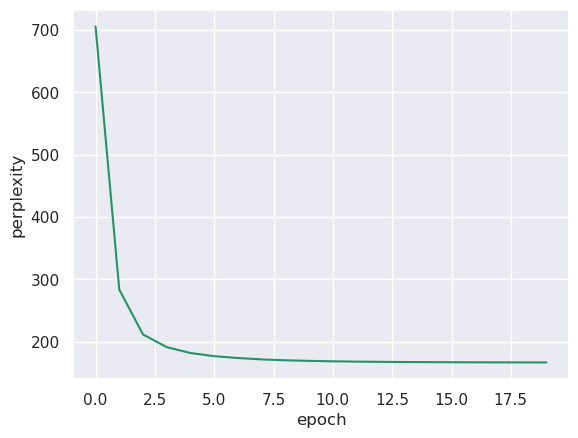

In [34]:
plt.plot(perplexities4)
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.show()

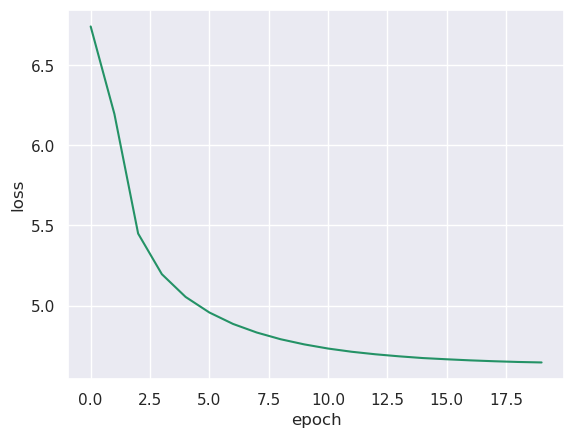

In [35]:
plt.plot(losses4)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

Тут переобучения не происходит и перплексия также выходит на плато.

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

##### Cравним графики для всех моделей

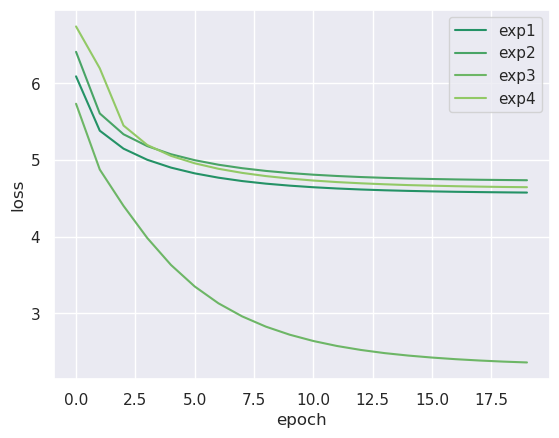

In [36]:
plt.plot(losses, label="exp1")
plt.plot(losses2, label="exp2")
plt.plot(losses3, label="exp3")
plt.plot(losses4, label="exp4")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

Наименьший лосс на тренировочном датасете был достигнут при увеличени размера скрытого состояния в 4 раза.

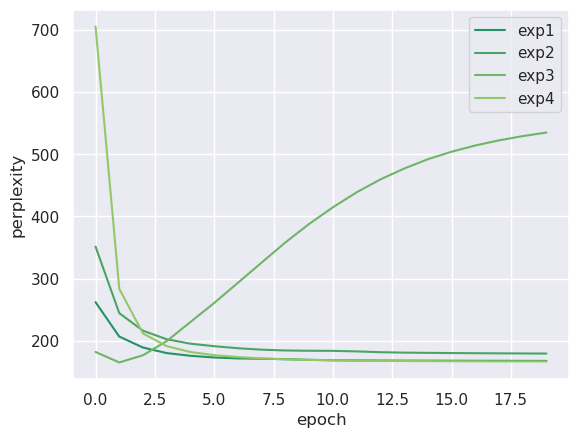

In [37]:
plt.plot(perplexities, label="exp1")
plt.plot(perplexities2, label="exp2")
plt.plot(perplexities3, label="exp3")
plt.plot(perplexities4, label="exp4")
plt.xlabel("epoch")
plt.ylabel("perplexity")
plt.legend()
plt.show()

Сделаем таблицу с минимальными значениями перплексии для моделей.

In [38]:
results = pd.DataFrame(
    {
        "Модель": range(4),
        "Минимальная перплексия": [min(perp) for perp in [perplexities, perplexities2, perplexities3, perplexities4]]
    }
)
results

,Модель,Минимальная перплексия
0,0,167.424542
1,1,179.264911
2,2,164.983576
3,3,166.618527


Минимальной перплексией на валидационном датасете без переобучения обладает модель 4.

### Генерация текста

Попробуем погенерировать текст нашими моделями.

In [39]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    processed_starting_seq = starting_seq.lower().translate(str.maketrans('', '', string.punctuation))
    device = "cpu"
    model.eval()
    model = model.to(device)
    input_ids = [word2ind["<bos>"]] + [word2ind.get(word, word2ind["<unk>"]) for word in word_tokenize(processed_starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_dist = model(input_ids)[-1]
            next_word = next_word_dist.argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind["<eos>"]:
                break

    return ' '.join([ind2word.get(idx) for idx in input_ids.numpy()])

In [40]:
def generate_sequence_for_each_model(starting_seq):
    print(f"Начало: {starting_seq}")
    for i, language_model in enumerate([model, model2, model3, model4], 1):
        print(f"Модель {i}: {generate_sequence(language_model, starting_seq)}")

In [41]:
generate_sequence_for_each_model("The movie was ")

Начало: The movie was 

Модель 1: <bos> the movie was a bit too much <eos>

Модель 2: <bos> the movie was a bit more like a <unk> <eos>

Модель 3: <bos> the movie was a great disappointment for me <eos>

Модель 4: <bos> the movie was a bit too long <eos>


Тут все модели показали сносное качество, кроме модели 2.

In [42]:
generate_sequence_for_each_model("The movie is so awful because ")

Начало: The movie is so awful because 

Модель 1: <bos> the movie is so awful because it is a great movie <eos>

Модель 2: <bos> the movie is so awful because it is a very good movie <eos>

Модель 3: <bos> the movie is so awful because it is so bad that it becomes very annoying <eos>

Модель 4: <bos> the movie is so awful because it is a very good movie <eos>


В данном случае все модели, кроме самой переобученной модели 3 не смогли продолжить смысл начала фразы.

In [43]:
generate_sequence_for_each_model("The main actor was ")

Начало: The main actor was 

Модель 1: <bos> the main actor was a great actor and he is a great actor <eos>

Модель 2: <bos> the main actor was the only thing that was going to be about <eos>

Модель 3: <bos> the main actor was just as good <eos>

Модель 4: <bos> the main actor was the only thing that was going to be the best of the movie <eos>


Тут сложно выбрать лучшую модель, скорее что-то похожее на правду выдала 4 модель.

In [44]:
generate_sequence_for_each_model("They should have ")

Начало: They should have 

Модель 1: <bos> they should have been a good movie <eos>

Модель 2: <bos> they should have been a good movie <eos>

Модель 3: <bos> they should have just made a good movie with some good friends and it was so bad that it would be good to <unk> br the acting was good <eos>

Модель 4: <bos> they should have been a big <unk> br the movie is a bit too long <eos>


В данном случае ни одна модель не сгенерировала сносный текст, но самая переобученная выдала самое длинное предложение.

In [45]:
generate_sequence_for_each_model("The plot was ")

Начало: The plot was 

Модель 1: <bos> the plot was very good <eos>

Модель 2: <bos> the plot was so bad that it was a bit more than a movie <eos>

Модель 3: <bos> the plot was so predictable <eos>

Модель 4: <bos> the plot was so bad that i was very disappointed <eos>


В принципе все модели, кроме второй, выдали что-то похожее на правду.

### Общий вывод

Эксперименты показали, что наилучшее качество на тренировочной выборке можно достигнуть увеличением размера скрытого состояния.

Нужно только победить переобучение, возможно подобрать другой learning rate, или немного упростить структуру модели (например, сделать меньший размер скрытого состояния).